In [1]:
import sys
sys.path.append('../')

from model import *
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pickle as pkl
import matplotlib.pyplot as plt
import sklearn
import numpy as np

### Data

In [2]:
with open('../../data/ChildWelfare/X_preprocess.pkl', 'rb') as handle:
    X,screener_ids,refer_ids,Y_obs,D,Y_serv,Y_sub,colnames = pkl.load(handle)

In [3]:
X.shape

(46544, 216)

In [4]:
#add intercept column if needed
#X = np.append(X,np.ones((X.shape[0],1)),axis=1)
#X.shape

In [5]:
#drop instances if expert assessed less than a certain number of cases

drop_experts = []
for num in screener_ids:

    if screener_ids.count(num) < 10:

        drop_experts.append(num)

In [6]:
drop_idx = []
for index, elem in enumerate(screener_ids):
    if elem in drop_experts:
        drop_idx.append(index)

In [7]:
X = np.delete(X,drop_idx,axis=0)
Y_serv = np.delete(Y_serv,drop_idx,axis=0)
Y_sub = np.delete(Y_sub,drop_idx,axis=0)
Y_obs = np.delete(Y_obs,drop_idx,axis=0)
D = np.delete(D,drop_idx,axis=0)
refer_ids = np.delete(refer_ids,drop_idx,axis=0)
screener_ids = np.delete(screener_ids,drop_idx,axis=0)

In [8]:
D = D.reshape((D.shape[0],))
Y_obs = Y_obs.reshape((Y_obs.shape[0],))

In [9]:
target = pd.DataFrame({'D': D, 'Y1': Y_obs, 'Y2': Y_serv, 'Y3': Y_sub})

Split data in a 80% train, 20% test

In [12]:
cov_train, cov_test, tar_train, tar_test, nur_train, nur_test = train_test_split(pd.DataFrame(X), target, pd.Series(screener_ids), test_size = 0.2, random_state = 0)

### Modelling

In [13]:
# Model's characteristics
params = {'layers': []} # If = [] equivalent to a simple logistic regression

# Amalgation parameters
rho = 0.05 # Control which point to consider from a confience point of view
pi_1 = 4.0 # Control criterion on centre mass metric
pi_2 = 0.8 # Control criterion on opposing metric
tau = 1.0  # Balance between observed and expert labels

##### 1. Train on decision

This model models the nurse decision based on covariates

In [14]:
for l1_penalty in [ 1.0, 10.0, 15.0, 20.0, 25, 30.0, 50.0]:
    try:
        model = BinaryMLP(**params)
        model = model.fit(cov_train, tar_train['D'], nur_train, l1_penalty = l1_penalty)
        break
    except Exception as e:
        print(e, l1_penalty)
        pass

Loss: 0.550:  10%|▉         | 99/1000 [00:56<06:11,  2.42it/s]

In [15]:
Y_pred_h_test = model.predict(cov_test)

In [16]:
print("Y1", roc_auc_score(tar_test['Y1'], Y_pred_h_test))

print("Y2", roc_auc_score(tar_test['Y2'], Y_pred_h_test))

print("Y3", roc_auc_score(tar_test['Y3'], Y_pred_h_test))

print("D", roc_auc_score(tar_test['D'], Y_pred_h_test))

Y1 0.687411112598161
Y2 0.8409013647919947
Y3 0.9768344125052812
D 0.8088342377982011


##### 2. Agreement computation 

Measure of agreeability are estimated in a cross validation fashion on the train set.

In [19]:
# Fold evaluation of influences
folds, predictions, influence = influence_cv(BinaryMLP, cov_train, tar_train['D'], nur_train, params = params, fit_params = {"l1_penalty": 10})




  0%|          | 0/1000 [00:00<?, ?it/s]


Loss: 0.678:   0%|          | 0/1000 [00:00<?, ?it/s]


Loss: 0.678:   0%|          | 1/1000 [00:00<12:55,  1.29it/s]


Loss: 0.669:   0%|          | 1/1000 [00:01<12:55,  1.29it/s]


Loss: 0.669:   0%|          | 2/1000 [00:01<13:04,  1.27it/s]


Loss: 0.664:   0%|          | 2/1000 [00:02<13:04,  1.27it/s]


Loss: 0.664:   0%|          | 3/1000 [00:02<12:50,  1.29it/s]


Loss: 0.661:   0%|          | 3/1000 [00:02<12:50,  1.29it/s]


Loss: 0.661:   0%|          | 4/1000 [00:02<11:53,  1.39it/s]


Loss: 0.657:   0%|          | 4/1000 [00:03<11:53,  1.39it/s]


Loss: 0.657:   0%|          | 5/1000 [00:03<10:27,  1.59it/s]


Loss: 0.656:   0%|          | 5/1000 [00:04<10:27,  1.59it/s]


Loss: 0.656:   1%|          | 6/1000 [00:04<10:42,  1.55it/s]


Loss: 0.654:   1%|          | 6/1000 [00:04<10:42,  1.55it/s]


Loss: 0.654:   1%|          | 7/1000 [00:04<11:09,  1.48it/s]


Loss: 0.654:   1%|          | 7/1000 [00:05<11:09,  1.48it/s]


Lo

Loss: 0.651:   6%|▌         | 55/1000 [00:29<07:01,  2.24it/s]


Loss: 0.651:   6%|▌         | 56/1000 [00:29<06:46,  2.32it/s]


Loss: 0.650:   6%|▌         | 56/1000 [00:30<06:46,  2.32it/s]


Loss: 0.650:   6%|▌         | 57/1000 [00:30<06:18,  2.49it/s]


Loss: 0.650:   6%|▌         | 57/1000 [00:30<06:18,  2.49it/s]


Loss: 0.650:   6%|▌         | 58/1000 [00:30<05:45,  2.73it/s]


Loss: 0.650:   6%|▌         | 58/1000 [00:30<05:45,  2.73it/s]


Loss: 0.650:   6%|▌         | 59/1000 [00:30<05:20,  2.93it/s]


Loss: 0.651:   6%|▌         | 59/1000 [00:30<05:20,  2.93it/s]


Loss: 0.651:   6%|▌         | 60/1000 [00:30<05:08,  3.04it/s]


Loss: 0.649:   6%|▌         | 60/1000 [00:31<05:08,  3.04it/s]


Loss: 0.649:   6%|▌         | 61/1000 [00:31<04:53,  3.20it/s]


Loss: 0.651:   6%|▌         | 61/1000 [00:31<04:53,  3.20it/s]


Loss: 0.651:   6%|▌         | 62/1000 [00:31<04:36,  3.39it/s]


Loss: 0.652:   6%|▌         | 62/1000 [00:31<04:36,  3.39it/s]


Loss: 0.652:   6%|▋      

Loss: 0.651:  11%|█         | 110/1000 [00:44<04:25,  3.35it/s]


Loss: 0.651:  11%|█         | 111/1000 [00:44<04:16,  3.46it/s]


Loss: 0.651:  11%|█         | 111/1000 [00:45<04:16,  3.46it/s]


Loss: 0.651:  11%|█         | 112/1000 [00:45<04:02,  3.67it/s]


Loss: 0.650:  11%|█         | 112/1000 [00:45<04:02,  3.67it/s]


Loss: 0.650:  11%|█▏        | 113/1000 [00:45<04:00,  3.69it/s]


Loss: 0.651:  11%|█▏        | 113/1000 [00:45<04:00,  3.69it/s]


Loss: 0.651:  11%|█▏        | 114/1000 [00:45<03:53,  3.80it/s]


Loss: 0.651:  11%|█▏        | 114/1000 [00:45<03:53,  3.80it/s]


Loss: 0.651:  12%|█▏        | 115/1000 [00:45<03:45,  3.93it/s]


Loss: 0.651:  12%|█▏        | 115/1000 [00:46<03:45,  3.93it/s]


Loss: 0.651:  12%|█▏        | 116/1000 [00:46<03:45,  3.92it/s]


Loss: 0.651:  12%|█▏        | 116/1000 [00:46<03:45,  3.92it/s]


Loss: 0.651:  12%|█▏        | 117/1000 [00:46<04:10,  3.53it/s]


Loss: 0.651:  12%|█▏        | 117/1000 [00:46<04:10,  3.53it/s]


Loss: 0.65

Loss: 0.652:  16%|█▋        | 165/1000 [01:04<06:21,  2.19it/s]


Loss: 0.651:  16%|█▋        | 165/1000 [01:04<06:21,  2.19it/s]


Loss: 0.651:  17%|█▋        | 166/1000 [01:04<06:32,  2.13it/s]


Loss: 0.651:  17%|█▋        | 166/1000 [01:05<06:32,  2.13it/s]


Loss: 0.651:  17%|█▋        | 167/1000 [01:05<06:21,  2.18it/s]


Loss: 0.652:  17%|█▋        | 167/1000 [01:05<06:21,  2.18it/s]


Loss: 0.652:  17%|█▋        | 168/1000 [01:05<06:03,  2.29it/s]


Loss: 0.651:  17%|█▋        | 168/1000 [01:05<06:03,  2.29it/s]


Loss: 0.651:  17%|█▋        | 169/1000 [01:05<05:50,  2.37it/s]


Loss: 0.650:  17%|█▋        | 169/1000 [01:06<05:50,  2.37it/s]


Loss: 0.650:  17%|█▋        | 170/1000 [01:06<05:52,  2.35it/s]


Loss: 0.650:  17%|█▋        | 170/1000 [01:06<05:52,  2.35it/s]


Loss: 0.650:  17%|█▋        | 171/1000 [01:06<05:57,  2.32it/s]


Loss: 0.651:  17%|█▋        | 171/1000 [01:07<05:57,  2.32it/s]


Loss: 0.651:  17%|█▋        | 172/1000 [01:07<05:59,  2.30it/s]


Loss: 0.65

Loss: 0.652:  22%|██▏       | 219/1000 [01:31<08:06,  1.60it/s]


Loss: 0.652:  22%|██▏       | 220/1000 [01:31<07:17,  1.78it/s]


Loss: 0.652:  22%|██▏       | 220/1000 [01:32<07:17,  1.78it/s]


Loss: 0.652:  22%|██▏       | 221/1000 [01:32<06:37,  1.96it/s]


Loss: 0.651:  22%|██▏       | 221/1000 [01:32<06:37,  1.96it/s]


Loss: 0.651:  22%|██▏       | 222/1000 [01:32<06:38,  1.95it/s]


Loss: 0.651:  22%|██▏       | 222/1000 [01:33<06:38,  1.95it/s]


Loss: 0.651:  22%|██▏       | 223/1000 [01:33<07:07,  1.82it/s]


Loss: 0.650:  22%|██▏       | 223/1000 [01:33<07:07,  1.82it/s]


Loss: 0.650:  22%|██▏       | 224/1000 [01:33<07:13,  1.79it/s]


Loss: 0.651:  22%|██▏       | 224/1000 [01:34<07:13,  1.79it/s]


Loss: 0.651:  22%|██▎       | 225/1000 [01:34<07:07,  1.81it/s]


Loss: 0.650:  22%|██▎       | 225/1000 [01:34<07:07,  1.81it/s]


Loss: 0.650:  23%|██▎       | 226/1000 [01:34<06:42,  1.92it/s]


Loss: 0.650:  23%|██▎       | 226/1000 [01:35<06:42,  1.92it/s]


Loss: 0.65

Loss: 0.651:  27%|██▋       | 274/1000 [01:53<03:27,  3.51it/s]


Loss: 0.650:  27%|██▋       | 274/1000 [01:54<03:27,  3.51it/s]


Loss: 0.650:  28%|██▊       | 275/1000 [01:54<03:23,  3.57it/s]


Loss: 0.651:  28%|██▊       | 275/1000 [01:54<03:23,  3.57it/s]


Loss: 0.651:  28%|██▊       | 276/1000 [01:54<03:19,  3.63it/s]


Loss: 0.650:  28%|██▊       | 276/1000 [01:54<03:19,  3.63it/s]


Loss: 0.650:  28%|██▊       | 277/1000 [01:54<03:15,  3.71it/s]


Loss: 0.651:  28%|██▊       | 277/1000 [01:54<03:15,  3.71it/s]


Loss: 0.651:  28%|██▊       | 278/1000 [01:54<03:11,  3.76it/s]


Loss: 0.651:  28%|██▊       | 278/1000 [01:55<03:11,  3.76it/s]


Loss: 0.651:  28%|██▊       | 279/1000 [01:55<03:07,  3.85it/s]


Loss: 0.651:  28%|██▊       | 279/1000 [01:55<03:07,  3.85it/s]


Loss: 0.651:  28%|██▊       | 280/1000 [01:55<03:11,  3.76it/s]


Loss: 0.651:  28%|██▊       | 280/1000 [01:55<03:11,  3.76it/s]


Loss: 0.651:  28%|██▊       | 281/1000 [01:55<03:12,  3.73it/s]


Loss: 0.65

Loss: 0.651:  33%|███▎      | 328/1000 [02:10<03:47,  2.96it/s]


Loss: 0.651:  33%|███▎      | 329/1000 [02:10<03:58,  2.81it/s]


Loss: 0.651:  33%|███▎      | 329/1000 [02:10<03:58,  2.81it/s]


Loss: 0.651:  33%|███▎      | 330/1000 [02:10<03:57,  2.82it/s]


Loss: 0.652:  33%|███▎      | 330/1000 [02:10<03:57,  2.82it/s]


Loss: 0.652:  33%|███▎      | 331/1000 [02:10<03:53,  2.87it/s]


Loss: 0.651:  33%|███▎      | 331/1000 [02:11<03:53,  2.87it/s]


Loss: 0.651:  33%|███▎      | 332/1000 [02:11<03:50,  2.89it/s]


Loss: 0.651:  33%|███▎      | 332/1000 [02:11<03:50,  2.89it/s]


Loss: 0.651:  33%|███▎      | 333/1000 [02:11<03:41,  3.02it/s]


Loss: 0.651:  33%|███▎      | 333/1000 [02:11<03:41,  3.02it/s]


Loss: 0.651:  33%|███▎      | 334/1000 [02:11<03:35,  3.09it/s]


Loss: 0.651:  33%|███▎      | 334/1000 [02:11<03:35,  3.09it/s]


Loss: 0.651:  34%|███▎      | 335/1000 [02:11<03:32,  3.14it/s]


Loss: 0.651:  34%|███▎      | 335/1000 [02:12<03:32,  3.14it/s]


Loss: 0.65

Loss: 0.650:  38%|███▊      | 383/1000 [02:32<04:50,  2.12it/s]


Loss: 0.652:  38%|███▊      | 383/1000 [02:32<04:50,  2.12it/s]


Loss: 0.652:  38%|███▊      | 384/1000 [02:32<04:27,  2.30it/s]


Loss: 0.651:  38%|███▊      | 384/1000 [02:33<04:27,  2.30it/s]


Loss: 0.651:  38%|███▊      | 385/1000 [02:33<04:04,  2.51it/s]


Loss: 0.651:  38%|███▊      | 385/1000 [02:33<04:04,  2.51it/s]


Loss: 0.651:  39%|███▊      | 386/1000 [02:33<03:54,  2.62it/s]


Loss: 0.650:  39%|███▊      | 386/1000 [02:33<03:54,  2.62it/s]


Loss: 0.650:  39%|███▊      | 387/1000 [02:33<04:13,  2.42it/s]


Loss: 0.651:  39%|███▊      | 387/1000 [02:34<04:13,  2.42it/s]


Loss: 0.651:  39%|███▉      | 388/1000 [02:34<04:36,  2.21it/s]


Loss: 0.652:  39%|███▉      | 388/1000 [02:34<04:36,  2.21it/s]


Loss: 0.652:  39%|███▉      | 389/1000 [02:34<04:49,  2.11it/s]


Loss: 0.652:  39%|███▉      | 389/1000 [02:35<04:49,  2.11it/s]


Loss: 0.652:  39%|███▉      | 390/1000 [02:35<04:43,  2.15it/s]


Loss: 0.65

Loss: 0.651:   2%|▏         | 15/1000 [00:04<04:42,  3.49it/s]



Loss: 0.652:   2%|▏         | 15/1000 [00:04<04:42,  3.49it/s]



Loss: 0.652:   2%|▏         | 16/1000 [00:04<04:33,  3.60it/s]



Loss: 0.651:   2%|▏         | 16/1000 [00:04<04:33,  3.60it/s]



Loss: 0.651:   2%|▏         | 17/1000 [00:04<04:29,  3.65it/s]



Loss: 0.651:   2%|▏         | 17/1000 [00:05<04:29,  3.65it/s]



Loss: 0.651:   2%|▏         | 18/1000 [00:05<04:34,  3.57it/s]



Loss: 0.653:   2%|▏         | 18/1000 [00:05<04:34,  3.57it/s]



Loss: 0.653:   2%|▏         | 19/1000 [00:05<04:31,  3.62it/s]



Loss: 0.652:   2%|▏         | 19/1000 [00:05<04:31,  3.62it/s]



Loss: 0.652:   2%|▏         | 20/1000 [00:05<04:29,  3.64it/s]



Loss: 0.653:   2%|▏         | 20/1000 [00:05<04:29,  3.64it/s]



Loss: 0.653:   2%|▏         | 21/1000 [00:05<04:25,  3.68it/s]



Loss: 0.652:   2%|▏         | 21/1000 [00:06<04:25,  3.68it/s]



Loss: 0.652:   2%|▏         | 22/1000 [00:06<04:32,  3.59it/s]



Loss: 0.65

Loss: 0.652:   7%|▋         | 67/1000 [00:21<05:25,  2.87it/s]



Loss: 0.652:   7%|▋         | 68/1000 [00:21<05:32,  2.81it/s]



Loss: 0.651:   7%|▋         | 68/1000 [00:21<05:32,  2.81it/s]



Loss: 0.651:   7%|▋         | 69/1000 [00:21<06:07,  2.54it/s]



Loss: 0.653:   7%|▋         | 69/1000 [00:22<06:07,  2.54it/s]



Loss: 0.653:   7%|▋         | 70/1000 [00:22<06:22,  2.43it/s]



Loss: 0.652:   7%|▋         | 70/1000 [00:22<06:22,  2.43it/s]



Loss: 0.652:   7%|▋         | 71/1000 [00:22<06:01,  2.57it/s]



Loss: 0.652:   7%|▋         | 71/1000 [00:22<06:01,  2.57it/s]



Loss: 0.652:   7%|▋         | 72/1000 [00:22<06:05,  2.54it/s]



Loss: 0.651:   7%|▋         | 72/1000 [00:23<06:05,  2.54it/s]



Loss: 0.651:   7%|▋         | 73/1000 [00:23<05:57,  2.59it/s]



Loss: 0.652:   7%|▋         | 73/1000 [00:23<05:57,  2.59it/s]



Loss: 0.652:   7%|▋         | 74/1000 [00:23<05:55,  2.60it/s]



Loss: 0.653:   7%|▋         | 74/1000 [00:23<05:55,  2.60it/s]



Loss: 0.65

Loss: 0.653:   3%|▎         | 31/1000 [00:19<10:47,  1.50it/s]




Loss: 0.653:   3%|▎         | 32/1000 [00:19<11:03,  1.46it/s]




Loss: 0.654:   3%|▎         | 32/1000 [00:19<11:03,  1.46it/s]




Loss: 0.654:   3%|▎         | 33/1000 [00:19<11:17,  1.43it/s]




Loss: 0.654:   3%|▎         | 33/1000 [00:20<11:17,  1.43it/s]




Loss: 0.654:   3%|▎         | 34/1000 [00:20<11:35,  1.39it/s]




Loss: 0.654:   3%|▎         | 34/1000 [00:21<11:35,  1.39it/s]




Loss: 0.654:   4%|▎         | 35/1000 [00:21<11:04,  1.45it/s]




Loss: 0.653:   4%|▎         | 35/1000 [00:21<11:04,  1.45it/s]




Loss: 0.653:   4%|▎         | 36/1000 [00:21<10:30,  1.53it/s]




Loss: 0.654:   4%|▎         | 36/1000 [00:22<10:30,  1.53it/s]




Loss: 0.654:   4%|▎         | 37/1000 [00:22<10:39,  1.51it/s]




Loss: 0.654:   4%|▎         | 37/1000 [00:23<10:39,  1.51it/s]




Loss: 0.654:   4%|▍         | 38/1000 [00:23<10:25,  1.54it/s]




Loss: 0.653:   4%|▍         | 38/1000 [00:23<10:25,  1.54it/s]

In [20]:
# Compute metrics agreeability
center_metric, opposing_metric = compute_agreeability(influence)

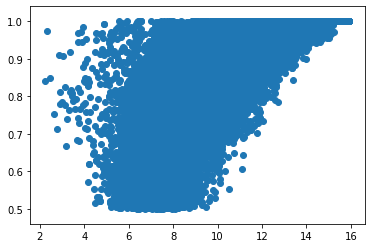

In [21]:
import matplotlib.pyplot as plt
plt.scatter(center_metric, opposing_metric)

In [22]:
# Apply criteria on amalgamation
high_conf = (predictions > (1 - rho)) | (predictions < rho)
high_agr = (center_metric > pi_1) & (opposing_metric > pi_2) & high_conf
high_agr_correct = ((predictions - tar_train['D']).abs() < rho) & high_agr

(array([  194.,  5911.,  6946., 11805.,  2212.,  1771.,   120.,   710.,
         4190.,  3363.]),
 array([0.18767194, 0.26885086, 0.35002978, 0.43120871, 0.51238763,
        0.59356655, 0.67474547, 0.75592439, 0.83710331, 0.91828223,
        0.99946116]),
 <a list of 10 Patch objects>)

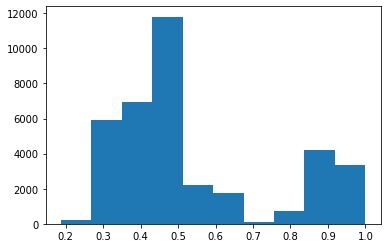

In [23]:
plt.hist(predictions)

In [24]:
print('high_conf:', sum(high_conf))
print('high_agr:', sum(high_agr))
print('high_agr_correct:', sum(high_agr_correct))

high_conf: 2682
high_agr: 2445
high_agr_correct: 2437


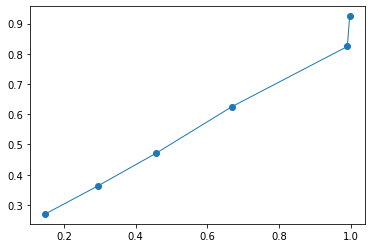

In [25]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(tar_train['D'], predictions, n_bins=7)
plt.plot(prob_true,prob_pred, marker='o', linewidth=1, label='logreg')


In [26]:
# Create amalgamated labels
tar_train['Ya'] = tar_train['Y1'].copy()
tar_train['Ya'][high_agr_correct] = (1 - tau) * tar_train['Y1'][high_agr_correct] \
                                    + tau * tar_train['D'][high_agr_correct]

In [27]:
sum(tar_train['D']!=tar_train['Y1'])

18236

In [28]:
sum(tar_train['Ya']!=tar_train['Y1'])

1959

In [29]:
#index for selective labels
index_amalg = [i==1.0 for i in tar_train['D']] | high_agr_correct

##### 3. Updated model

In [32]:
#model with selective labels
model = BinaryMLP(**params)
model = model.fit(cov_train[index_amalg], tar_train[index_amalg]['Ya'], nur_train[index_amalg], l1_penalty = l1_penalty)









  0%|          | 0/1000 [00:00<?, ?it/s]







Loss: 0.635:   0%|          | 0/1000 [00:00<?, ?it/s]







Loss: 0.635:   0%|          | 1/1000 [00:00<03:36,  4.61it/s]







Loss: 0.577:   0%|          | 1/1000 [00:00<03:36,  4.61it/s]







Loss: 0.577:   0%|          | 2/1000 [00:00<03:34,  4.65it/s]







Loss: 0.539:   0%|          | 2/1000 [00:00<03:34,  4.65it/s]







Loss: 0.539:   0%|          | 3/1000 [00:00<03:31,  4.72it/s]







Loss: 0.512:   0%|          | 3/1000 [00:00<03:31,  4.72it/s]







Loss: 0.512:   0%|          | 4/1000 [00:00<03:26,  4.82it/s]







Loss: 0.488:   0%|          | 4/1000 [00:01<03:26,  4.82it/s]







Loss: 0.488:   0%|          | 5/1000 [00:01<03:24,  4.85it/s]







Loss: 0.472:   0%|          | 5/1000 [00:01<03:24,  4.85it/s]







Loss: 0.472:   1%|          | 6/1000 [00:01<03:23,  4.87it/s]







Loss: 0.459:   1%|          | 6/1000 [00:01<03:23,  4.87it/s]







Loss: 0.459:   1%|          | 7/1000 [00:01<03:20,  4.9

Loss: 0.397:   4%|▍         | 43/1000 [00:09<03:36,  4.43it/s]







Loss: 0.397:   4%|▍         | 44/1000 [00:09<03:26,  4.63it/s]







Loss: 0.397:   4%|▍         | 44/1000 [00:09<03:26,  4.63it/s]







Loss: 0.397:   4%|▍         | 45/1000 [00:09<03:21,  4.74it/s]







Loss: 0.398:   4%|▍         | 45/1000 [00:09<03:21,  4.74it/s]







Loss: 0.398:   5%|▍         | 46/1000 [00:09<03:33,  4.47it/s]







Loss: 0.397:   5%|▍         | 46/1000 [00:10<03:33,  4.47it/s]







Loss: 0.397:   5%|▍         | 47/1000 [00:10<03:34,  4.44it/s]







Loss: 0.397:   5%|▍         | 47/1000 [00:10<03:34,  4.44it/s]







Loss: 0.397:   5%|▍         | 48/1000 [00:10<03:29,  4.54it/s]







Loss: 0.398:   5%|▍         | 48/1000 [00:10<03:29,  4.54it/s]







Loss: 0.398:   5%|▍         | 49/1000 [00:10<03:28,  4.56it/s]







Loss: 0.400:   5%|▍         | 49/1000 [00:10<03:28,  4.56it/s]







Loss: 0.400:   5%|▌         | 50/1000 [00:10<03:28,  4.57it/s]







Loss: 0.400:   5%|▌ 

In [33]:
Y_pred_amalg_test = model.predict(cov_test)

In [34]:
# #model without selective labels
# model = BinaryMLP(**params)
# model = model.fit(cov_train, tar_train['Ya'], nur_train[index_amalg])

In [35]:
print("Y1", roc_auc_score(tar_test['Y1'], Y_pred_amalg_test))

print("Y2", roc_auc_score(tar_test['Y2'], Y_pred_amalg_test))

print("Y3", roc_auc_score(tar_test['Y3'], Y_pred_amalg_test))

print("D", roc_auc_score(tar_test['D'], Y_pred_amalg_test))

Y1 0.7571513758381028
Y2 0.7965017838785754
Y3 0.9765326516418903
D 0.7200945873543061


##### 4. Train on observed data

In [36]:
model = BinaryMLP(**params)
model = model.fit(cov_train[tar_train['D']==1], tar_train['Y1'][tar_train['D']==1], nur_train, l1_penalty = l1_penalty)










  0%|          | 0/1000 [00:00<?, ?it/s]








Loss: 0.639:   0%|          | 0/1000 [00:00<?, ?it/s]








Loss: 0.639:   0%|          | 1/1000 [00:00<05:48,  2.87it/s]








Loss: 0.585:   0%|          | 1/1000 [00:00<05:48,  2.87it/s]








Loss: 0.585:   0%|          | 2/1000 [00:00<05:56,  2.80it/s]








Loss: 0.548:   0%|          | 2/1000 [00:01<05:56,  2.80it/s]








Loss: 0.548:   0%|          | 3/1000 [00:01<05:44,  2.89it/s]








Loss: 0.519:   0%|          | 3/1000 [00:01<05:44,  2.89it/s]








Loss: 0.519:   0%|          | 4/1000 [00:01<05:29,  3.02it/s]








Loss: 0.495:   0%|          | 4/1000 [00:01<05:29,  3.02it/s]








Loss: 0.495:   0%|          | 5/1000 [00:01<05:10,  3.21it/s]








Loss: 0.478:   0%|          | 5/1000 [00:01<05:10,  3.21it/s]








Loss: 0.478:   1%|          | 6/1000 [00:01<04:49,  3.44it/s]








Loss: 0.463:   1%|          | 6/1000 [00:02<04:49,  3.44it/s]








Loss: 0.463:   1%|          | 7/1000 [00

Loss: 0.399:   4%|▍         | 42/1000 [00:12<05:11,  3.07it/s]








Loss: 0.396:   4%|▍         | 42/1000 [00:12<05:11,  3.07it/s]








Loss: 0.396:   4%|▍         | 43/1000 [00:12<04:57,  3.22it/s]








Loss: 0.396:   4%|▍         | 43/1000 [00:13<04:57,  3.22it/s]








Loss: 0.396:   4%|▍         | 44/1000 [00:13<05:03,  3.15it/s]








Loss: 0.396:   4%|▍         | 44/1000 [00:13<05:03,  3.15it/s]








Loss: 0.396:   4%|▍         | 45/1000 [00:13<04:48,  3.31it/s]








Loss: 0.398:   4%|▍         | 45/1000 [00:13<04:48,  3.31it/s]








Loss: 0.398:   5%|▍         | 46/1000 [00:13<04:39,  3.41it/s]








Loss: 0.398:   5%|▍         | 46/1000 [00:14<04:39,  3.41it/s]








Loss: 0.398:   5%|▍         | 47/1000 [00:14<04:46,  3.33it/s]








Loss: 0.396:   5%|▍         | 47/1000 [00:14<04:46,  3.33it/s]








Loss: 0.396:   5%|▍         | 48/1000 [00:14<04:48,  3.30it/s]








Loss: 0.397:   5%|▍         | 48/1000 [00:14<04:48,  3.30it/s]








Loss: 

Loss: 0.399:   8%|▊         | 83/1000 [00:26<05:49,  2.62it/s]








Loss: 0.399:   8%|▊         | 84/1000 [00:26<06:56,  2.20it/s]








Loss: 0.398:   8%|▊         | 84/1000 [00:27<06:56,  2.20it/s]








Loss: 0.398:   8%|▊         | 85/1000 [00:27<08:05,  1.88it/s]








Loss: 0.399:   8%|▊         | 85/1000 [00:27<08:05,  1.88it/s]








Loss: 0.399:   9%|▊         | 86/1000 [00:27<08:31,  1.79it/s]








Loss: 0.395:   9%|▊         | 86/1000 [00:28<08:31,  1.79it/s]








Loss: 0.395:   9%|▊         | 87/1000 [00:28<08:44,  1.74it/s]








Loss: 0.397:   9%|▊         | 87/1000 [00:28<08:44,  1.74it/s]








Loss: 0.397:   9%|▉         | 88/1000 [00:28<08:16,  1.84it/s]








Loss: 0.395:   9%|▉         | 88/1000 [00:29<08:16,  1.84it/s]








Loss: 0.395:   9%|▉         | 89/1000 [00:29<07:58,  1.90it/s]








Loss: 0.397:   9%|▉         | 89/1000 [00:29<07:58,  1.90it/s]








Loss: 0.397:   9%|▉         | 90/1000 [00:29<07:13,  2.10it/s]








Loss: 

ValueError: Architecture leads to singular weights matrix for last layer: Use another architecture or increase l1_penalty.

In [37]:
Y_pred_obs_test = model.predict(cov_test)

In [38]:
print("Y1", roc_auc_score(tar_test['Y1'], Y_pred_obs_test))

print("Y2", roc_auc_score(tar_test['Y2'], Y_pred_obs_test))

print("Y3", roc_auc_score(tar_test['Y3'], Y_pred_obs_test))

print("D", roc_auc_score(tar_test['D'], Y_pred_obs_test))

Y1 0.7721738077929006
Y2 0.6943366127603188
Y3 0.7643287799703544
D 0.6203407866626443


#### 5. Retrain human without L1 penalty 

In [39]:
#if models trained without 1 penalty, retrain f_h
model = BinaryMLP(**params)
model = model.fit(cov_train, tar_train['D'], nur_train)











  0%|          | 0/1000 [00:00<?, ?it/s]









Loss: 0.611:   0%|          | 0/1000 [00:00<?, ?it/s]









Loss: 0.611:   0%|          | 1/1000 [00:00<13:29,  1.23it/s]









Loss: 0.589:   0%|          | 1/1000 [00:01<13:29,  1.23it/s]









Loss: 0.589:   0%|          | 2/1000 [00:01<13:41,  1.21it/s]









Loss: 0.577:   0%|          | 2/1000 [00:02<13:41,  1.21it/s]









Loss: 0.577:   0%|          | 3/1000 [00:02<13:55,  1.19it/s]









Loss: 0.570:   0%|          | 3/1000 [00:03<13:55,  1.19it/s]









Loss: 0.570:   0%|          | 4/1000 [00:03<14:16,  1.16it/s]









Loss: 0.563:   0%|          | 4/1000 [00:04<14:16,  1.16it/s]









Loss: 0.563:   0%|          | 5/1000 [00:04<14:14,  1.16it/s]









Loss: 0.556:   0%|          | 5/1000 [00:05<14:14,  1.16it/s]









Loss: 0.556:   1%|          | 6/1000 [00:05<13:41,  1.21it/s]









Loss: 0.551:   1%|          | 6/1000 [00:05<13:41,  1.21it/s]









Loss: 0.551:   1%|       

KeyboardInterrupt: 

In [ ]:
Y_pred_h_test = model.predict(cov_test)

print(roc_auc_score(tar_test['Y1'], model.predict(cov_test)))

print(roc_auc_score(tar_test['Y2'], model.predict(cov_test)))

print(roc_auc_score(tar_test['Y3'], model.predict(cov_test)))

print(roc_auc_score(tar_test['D'], model.predict(cov_test)))

## Precision/Accuracy

In [40]:
def eval_pred_outcome(Y_outcome_test, Y_pred_test, Y_h_test, p):
    Y_pred_test_scrin = Y_pred_test[Y_h_test==1]
    Y_outcome_test_scrin = Y_outcome_test[Y_h_test==1]
    #print(sum(Y_outcome_test_scrin))
    idx_25qrtl_pred = np.argsort(Y_pred_test_scrin)[::-1][:int(np.floor(p*len(Y_pred_test_scrin)))]
    #baseline
    baseline = sum(Y_outcome_test_scrin)/len(Y_outcome_test_scrin)
    #print(idx_25qrtl_pred )
    #print(sum(Y_outcome_test_scrin[idx_25qrtl_pred]))
    #precision and recall in top p% highsest scored screen-in
    precision_p = sum(Y_outcome_test_scrin[idx_25qrtl_pred])/len(idx_25qrtl_pred)
    recall_p = sum(Y_outcome_test_scrin[idx_25qrtl_pred])/sum(Y_outcome_test)
    
    return baseline, precision_p, recall_p

In [41]:
print('Eval resp. Y_obs')
print('f_y', eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_obs_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_A', eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_amalg_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_h', eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_h_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))

Eval resp. Y_obs
f_y (0.12117576484703059, 0.2768, 0.4441591784338896)
f_A (0.12117576484703059, 0.2528, 0.4056482670089859)
f_h (0.12117576484703059, 0.1888, 0.3029525032092426)


In [42]:
print('Eval resp. Y_serv')
print('f_y', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_obs_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_A', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_amalg_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_h', eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_h_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))

Eval resp. Y_serv
f_y (0.4231153769246151, 0.6264, 0.3700378071833648)
f_A (0.4231153769246151, 0.704, 0.4158790170132325)
f_h (0.4231153769246151, 0.7144, 0.4220226843100189)


In [43]:
print('Eval resp. Y_sub')
print('f_y', eval_pred_outcome(np.array(tar_test['Y3']).flatten(), Y_pred_obs_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_A', eval_pred_outcome(np.array(tar_test['Y3']).flatten(), Y_pred_amalg_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))
print('f_h', eval_pred_outcome(np.array(tar_test['Y3']).flatten(), Y_pred_h_test.flatten(), np.array(tar_test['D']==1).flatten(), 0.25))

Eval resp. Y_sub
f_y (0.4527094581083783, 0.7504, 0.41431095406360424)
f_A (0.4527094581083783, 0.9784, 0.5401943462897526)
f_h (0.4527094581083783, 0.9952, 0.549469964664311)


In [44]:
def eval_pred(Y_pred_test, tar_test, p):
    dic_k_Y_pred = {}
    
    base_ooh, precision_ooh, recall_ooh = eval_pred_outcome(np.array(tar_test['Y1']).flatten(), Y_pred_test.flatten(), np.array(tar_test['D']==1).flatten(), p)
    base_serv, precision_serv, recall_serv = eval_pred_outcome(np.array(tar_test['Y2']).flatten(), Y_pred_test.flatten(), np.array(tar_test['D']==1).flatten(), p)
    base_sub, precision_sub, recall_sub = eval_pred_outcome(np.array(tar_test['Y3']).flatten(), Y_pred_test.flatten(), np.array(tar_test['D']==1).flatten(), p)
    
    dic_k_Y_pred['ooh'] = {'base': float(base_ooh), 'precision': float(precision_ooh), 'recall': float(recall_ooh)}
    dic_k_Y_pred['sub'] = {'base': float(base_sub), 'precision': float(precision_sub), 'recall': float(recall_sub)}
    dic_k_Y_pred['serv'] = {'base': float(base_serv), 'precision': float(precision_serv), 'recall': float(recall_serv)}
    
    return dic_k_Y_pred
    

In [45]:
def eval_k_iter(Y_pred_obs_test, Y_pred_amalg_test, Y_pred_h_test, tar_test, p):
    dic_eval = {}
    
    dic_k = {}
    dic_k['Y_pred_obs_test'] = eval_pred(Y_pred_obs_test, tar_test, p)
    dic_k['Y_pred_h_test'] = eval_pred(Y_pred_h_test, tar_test, p)
    #dic_k['Y_pred_hybrid_test'] = eval_pred(Y_pred_hybrid_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
    #print('done with Y_pred_hyb_test')
    dic_k['Y_pred_amalg_test'] = eval_pred(Y_pred_amalg_test, tar_test, p)

    
    dic_eval[0] = dic_k
    
    return dic_eval

In [46]:
list_dics =[]
for p in np.arange(0.05, 0.4, 0.05):
    list_dics.append(eval_k_iter(Y_pred_obs_test, Y_pred_amalg_test, Y_pred_h_test, tar_test, p))

In [47]:
dic_25 = eval_k_iter(Y_pred_obs_test, Y_pred_amalg_test, Y_pred_h_test, tar_test, 0.25)

In [48]:
def plot_perf_bar(dic_eval, models = ['Y_pred_obs_test', 'Y_pred_h_test',
                                     'Y_pred_hybrid_test', 'Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$', '$f_\mathcal{hyb}$',  '$f_\mathcal{A}$' ] ,
                  labels = ['ooh', 'sub', 'serv'], y_max=1.05, legend_appear=True,
                  metric ='precision', fig_title='fig_noname'):
    
    K = len(dic_eval.keys())
    
    n_labels = len(labels)
    
    fig, ax = plt.subplots(figsize=(10,5))
    index = np.arange(n_labels)
    bar_width = 0.15
    opacity = 0.8
    colors = ['green', 'darkred', 'yellow', 'blue']
    hatches = ['//', '-', '\\', '.']
    
    
    m_idx =0
    for m in models:
        plot_mean = [0]*n_labels
        plot_std = [0]*n_labels
        
        l_idx = 0
        for l in labels:
            metric_list = [0]*K
            if metric == 'precision':
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['precision']
            
            if metric == 'recall':
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['recall']
            plot_mean[l_idx] = np.mean(metric_list)  
            plot_std[l_idx] = np.std(metric_list)  
            l_idx += 1
        rects = plt.bar(index+m_idx*bar_width, plot_mean, yerr= plot_std,
            alpha=opacity, color=colors[m_idx], capsize=7,  width=.1, hatch = hatches[m_idx],
                            label=plot_labels[m_idx])        
            
            
        m_idx+=1                
    
    
    for n in index[:-1]:
        if metric=='precision':
            t= 0.8
        else:
            t=0.7
        plt.axvline(x=n+t, color='grey', linestyle='--')
        
    if metric=='precision':
        plot_mean = [0]*n_labels
        plot_std = [0]*n_labels
        l_idx = 0
        for l in labels:
            metric_list = [0]*K
            for k in range(K):
                metric_list[k] = dic_eval[k][m][l]['base']
            plot_mean[l_idx] = np.mean(metric_list)  
            plot_std[l_idx] = np.std(metric_list) 
            l_idx +=1
        rects = plt.bar(index+len(models)*bar_width, plot_mean, yerr= plot_std,
            alpha=opacity, color='grey',capsize=7,  width=.1,label='Overall prev.')     

    plt.ylabel(metric,fontsize=25)
    #plt.ylim((0,1.05))
    #plt.title('Performance of outcomes by model',fontsize=18)
    plt.xticks(index + 1.5*bar_width, ('OOH', 'Substantiated', 'Services'),fontsize=18)
    plt.yticks(fontsize=16)
    if legend_appear==True:
        plt.legend(loc = 'upper left', fontsize=18)
    plt.ylim(0.0,y_max)
    plt.tight_layout()

#     plt.savefig(fig_title, dpi=300,
#             orientation='portrait' )
    plt.show()

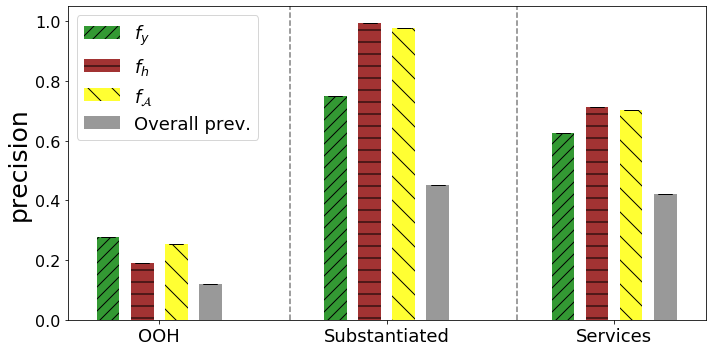

In [49]:
plot_perf_bar(dic_25, models = ['Y_pred_obs_test', 'Y_pred_h_test', 'Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$',   '$f_\mathcal{A}$' ])

In [50]:
def plot_perf_bar(list_dics, index = np.arange(0.05, 0.4, 0.05), models = ['Y_pred_obs_test', 'Y_pred_h_test',
                                     'Y_pred_hybrid_test', 'Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$', '$f_\mathcal{hyb}$',  '$f_\mathcal{A}$' ] ,
                  labels = ['ooh', 'sub', 'serv'], y_max=1.05, legend_appear=True,
                  metric ='precision', fig_title='fig_noname'):
    
    K = len(list_dics[0].keys())
    
    n_groups = len(labels)
    
    fig, ax_list = plt.subplots(1,n_groups, figsize=(14,5))
    N=len(list_dics)
    
    bar_width = 0.1
    opacity = 0.8
    colors = ['green', 'darkred', 'goldenrod', 'blue']
    hatches = ['//', '-', '\\', '.']
    l_idx = 0
    for l in labels:
        m_idx =0
        for m in models:
            plot_mean = [0]*N
            plot_std = [0]*N

            dic_idx = 0
            for dic_eval in list_dics:
                metric_list = [0]*K
                if metric == 'precision':
                    for k in range(K):
                        metric_list[k] = dic_eval[k][m][l]['precision']

                if metric == 'recall':
                    for k in range(K):
                        metric_list[k] = dic_eval[k][m][l]['recall']
                plot_mean[dic_idx] = np.mean(metric_list)  
                plot_std[dic_idx] = np.std(metric_list)  
                dic_idx += 1
            ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
                alpha=opacity, color=colors[m_idx], capsize=7, 
                               label=plot_labels[m_idx])        
#             else:
#                 ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
#                 alpha=opacity, color=colors[m_idx], capsize=7)     

            m_idx+=1                
        

#         for n in index[:-1]:
#             if metric=='precision':
#                 t= (len(list_dics)-1)*bar_width+0.2
#             else:
#                 t= len(list_dics)*bar_width
#             plt.axvline(x=n+t, color='grey', linestyle='--')

        if metric=='precision':
            plot_mean = [0]*N
            plot_std = [0]*N
            dic_idx = 0
            for dic_eval in list_dics:
                metric_list = [0]*K
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['base']
                plot_mean[dic_idx] = np.mean(metric_list)  
                plot_std[dic_idx] = np.std(metric_list) 
                dic_idx +=1
            ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
                alpha=opacity, color='grey',capsize=7, label='base')     
#             else:
#                 ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
#                 alpha=opacity, color='grey',capsize=7)     
        l_idx+=1
        
        
   # plt.ylabel(metric,fontsize=25)
    ax_list[0].set_ylabel(metric,fontsize=20)
    ax_list[1].set_xlabel('top p%',fontsize=20)
    
    for k in range(n_groups):
        ax_list[k].set_title(labels[k],fontsize=20)
    
    
    ax_list[2].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18)
    
    #ax_list[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        #  fancybox=True, shadow=True, ncol=5)
    
    #plt.xticks(index+dic_idx*bar_width)
    
#     plt.yticks(fontsize=16)
#     if legend_appear==True:
#         plt.legend(loc = 'upper left', fontsize=18)
    #plt.ylim(0.0,y_max)
    #plt.tight_layout()

#     plt.savefig(fig_title, dpi=300,
#             orientation='portrait' )
    plt.show()

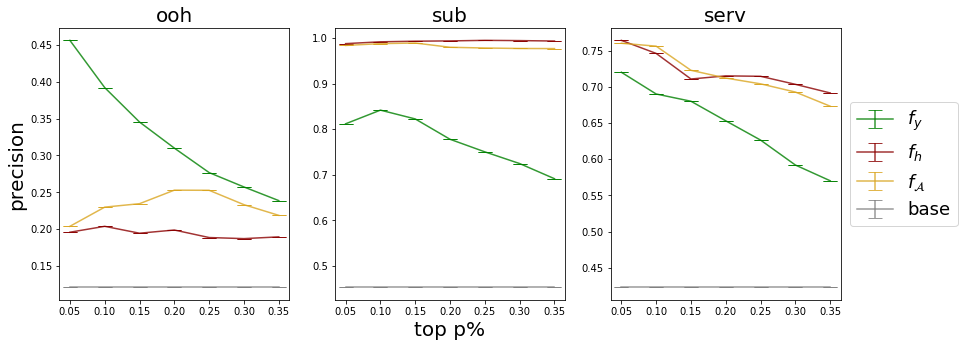

In [51]:
plot_perf_bar(list_dics, index = np.arange(0.05, 0.4, 0.05), models = ['Y_pred_obs_test', 'Y_pred_h_test','Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$',  '$f_\mathcal{A}$' ])